In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X = pd.read_csv("C:\\Users\\carlo\\OneDrive - Danmarks Tekniske Universitet\\1st Year 1st Semester\\02452 Machine Learning\\project1-ml\\data\\ObesityDataSet_Clean.csv")


### Clean Dataset

In [32]:
def dataset_setup(df, all_attributes=False):
    if(all_attributes):
        X = df.drop(columns="Weight")

    else:
        #attributes_used = ["Age", "Gender", "Height", "family_history_with_overweight", "CAEC"]
        attributes_used = df.drop(columns=["Weight", "CALC", "MTRANS", "SMOKE", "SCC", "CH2O", "CAEC"]).columns
        X = df[attributes_used]

    return X, df["Weight"]

X, y = dataset_setup(df, all_attributes=True)
X.head()

,Gender,Age,Height,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.80,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.80,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation,Overweight_Level_II


In [33]:
NOBD = pd.Categorical(X["NObeyesdad"], ordered=True)

print(NOBD)

['Normal_Weight', 'Normal_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', ..., 'Obesity_Type_III', 'Obesity_Type_III', 'Obesity_Type_III', 'Obesity_Type_III', 'Obesity_Type_III']
Length: 2111
Categories (7, object): ['Insufficient_Weight' < 'Normal_Weight' < 'Obesity_Type_I' < 'Obesity_Type_II' < 'Obesity_Type_III' < 'Overweight_Level_I' < 'Overweight_Level_II']


In [34]:
categorical_attributes = X.drop(columns=["Age", "Height"]).columns
X = pd.get_dummies(X, columns=categorical_attributes, drop_first=True, dtype=int)
X.head()

,Age,Height,Gender_Male,family_history_with_overweight_yes,FAVC_yes,FCVC_2,FCVC_3,NCP_2,NCP_3,CAEC_Frequently,...,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad_Normal_Weight,NObeyesdad_Obesity_Type_I,NObeyesdad_Obesity_Type_II,NObeyesdad_Obesity_Type_III,NObeyesdad_Overweight_Level_I,NObeyesdad_Overweight_Level_II
0,21,1.62,0,1,0,1,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
1,21,1.52,0,1,0,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0
2,23,1.80,1,1,0,1,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
3,27,1.80,1,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
4,22,1.78,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


### Find Best H in ANN

Fold 1/3
  Hidden units: 1, Validation set MSE: 743.7146
  Hidden units: 2, Validation set MSE: 361.9969
  Hidden units: 3, Validation set MSE: 240.8671
  Hidden units: 10, Validation set MSE: 60.7643
  Hidden units: 15, Validation set MSE: 43.7090
  Hidden units: 50, Validation set MSE: 21.1044
Fold 2/3
  Hidden units: 1, Validation set MSE: 687.5157
  Hidden units: 2, Validation set MSE: 353.8286
  Hidden units: 3, Validation set MSE: 211.1820
  Hidden units: 10, Validation set MSE: 58.1091
  Hidden units: 15, Validation set MSE: 41.4528
  Hidden units: 50, Validation set MSE: 22.0142
Fold 3/3
  Hidden units: 1, Validation set MSE: 731.3571
  Hidden units: 2, Validation set MSE: 370.5498
  Hidden units: 3, Validation set MSE: 215.9048
  Hidden units: 10, Validation set MSE: 62.4698
  Hidden units: 15, Validation set MSE: 44.8000
  Hidden units: 50, Validation set MSE: 26.3652


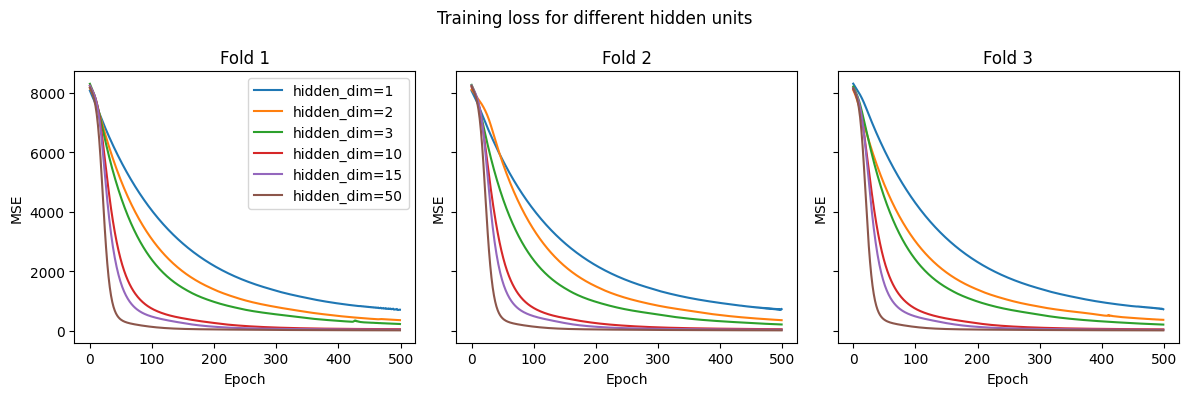

In [35]:
def get_model(input_dim, hidden_dim, output_dim):
    ### BEGIN SOLUTION
    return torch.nn.Sequential(
        torch.nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=True),     # Input layer
        torch.nn.Tanh(),                                                                # Activation function
        torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True),    # Output layer
    )


# K-fold crossvalidation
K = 3
CV = KFold(K, shuffle=True, random_state=0)

# Define hyperparameters
lr = 1e-3
n_epochs = 500

# Seed for reproducibility
seed = 0

# Hyperparameter tuning loop with K-fold crossvalidation
hyperparameters_to_tune = [1, 2, 3, 10, 15, 50]

results = {}
for k, (train_index, val_index) in enumerate(CV.split(X, y)):
    print(f'Fold {k+1}/{K}')
    
    # Get the training and test data for this fold
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]


    # Normalize data here
    mean, std = X_train.mean(axis=0), X_train.std(axis=0)
    X_train = (X_train - mean) / std
    X_val = (X_val - mean) / std

    # Convert to torch tensors
    # use the underlying numpy arrays (.values / .to_numpy()) to avoid
    # ambiguity when converting pandas Series/DataFrame to torch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

    input_dim  = X_train_tensor.shape[1]  # Number of features
    hidden_dim = 2
    output_dim = 1


    # Set up a dictionary to store the results for each hyperparameter setting
    results_inner = {hidden_dim: {'train': [], 'val': []} for hidden_dim in hyperparameters_to_tune}

    # Loop over the hyperparameter settings        
    for hidden_dim in hyperparameters_to_tune:
        # Define a model instance with a specific number of hidden units
        model = get_model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

        # Define loss criterion
        criterion = torch.nn.MSELoss()

        # Define the optimizer as the Adam optimizer (not needed to know the details)
        optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)
        
        for epoch in range(n_epochs):
            # Implement the training loop here
            # Set the model to training mode
            model.train()

            # Make a forward pass through the model to compute the outputs
            outputs = model(X_train_tensor)
            # Compute the loss
            loss = criterion(outputs, y_train_tensor)

            # Make sure that the gradients are zero before you use backpropagation
            optimizer.zero_grad()
            # Do a backward pass to compute the gradients wrt. model parameters using backpropagation.
            loss.backward()
            # Update the model parameters by making the optimizer take a gradient descent step
            optimizer.step()

            # Store the training loss for this epoch in the dictionary
            results_inner[hidden_dim]['train'].append(loss.item())

        # Compute the final test loss on the test set
        with torch.no_grad(): # No need to compute gradients for the validation set
            model.eval()
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            results_inner[hidden_dim]['val'].append(val_loss.item())
            print(f'  Hidden units: {hidden_dim}, Validation set MSE: {val_loss.item():.4f}')

    # Store the results for this fold
    results[k] = results_inner


# Plot the loss curves for each fold and hyperparameter setting
fig, axs = plt.subplots(1, K, figsize=(12, 4), sharey=True, sharex=True)
# Plot the training loss for each fold and hyperparameter setting
for fold in range(K):
    for hidden_dim in hyperparameters_to_tune:
        # Plot the training loss for this hyperparameter setting
        axs[fold].plot(results[fold][hidden_dim]['train'], label=f'hidden_dim={hidden_dim}')

    # Set the title and labels for each subplot
    axs[fold].set_title('Fold {}'.format(fold+1))
    axs[fold].set_xlabel('Epoch')
    axs[fold].set_ylabel('MSE')

# Set the overall title and show the legend
plt.suptitle('Training loss for different hidden units')
plt.tight_layout()
axs[0].legend()
plt.show()


### Find best λ in Linear Regression

Fold 1/3
  λ=0.0001  MSE=22.1369
  λ=0.001   MSE=22.1369
  λ=0.01    MSE=22.1375
  λ=0.1     MSE=22.1427
  λ=1       MSE=22.2023
  λ=10      MSE=23.4925
  λ=100     MSE=54.3185


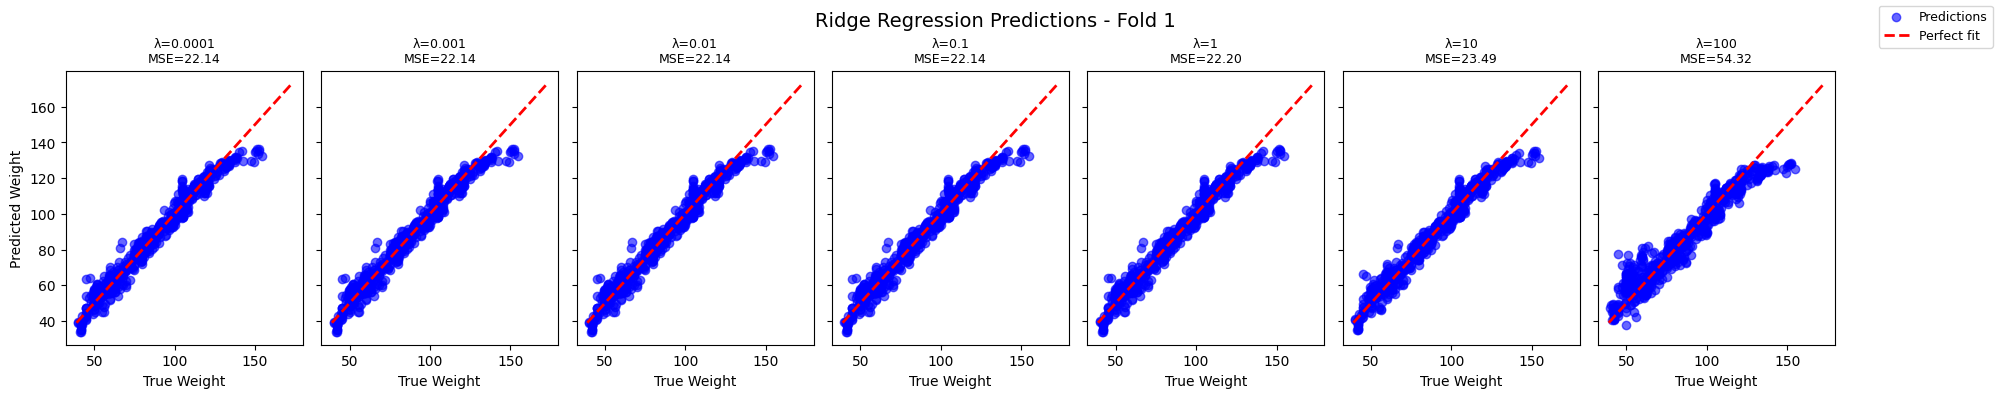

Fold 2/3
  λ=0.0001  MSE=25.4079
  λ=0.001   MSE=25.4078
  λ=0.01    MSE=25.4069
  λ=0.1     MSE=25.3980
  λ=1       MSE=25.3220
  λ=10      MSE=25.4533
  λ=100     MSE=50.9041


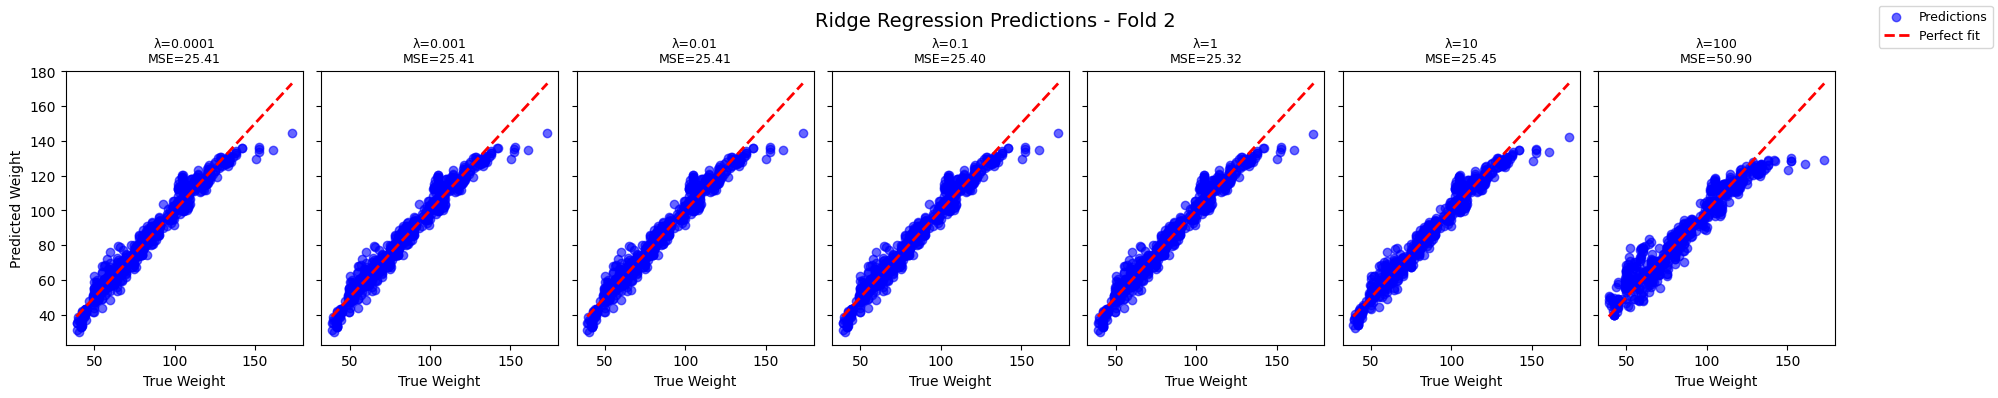

Fold 3/3
  λ=0.0001  MSE=27.6435
  λ=0.001   MSE=27.6435
  λ=0.01    MSE=27.6436
  λ=0.1     MSE=27.6451
  λ=1       MSE=27.6663
  λ=10      MSE=28.4315
  λ=100     MSE=52.1260


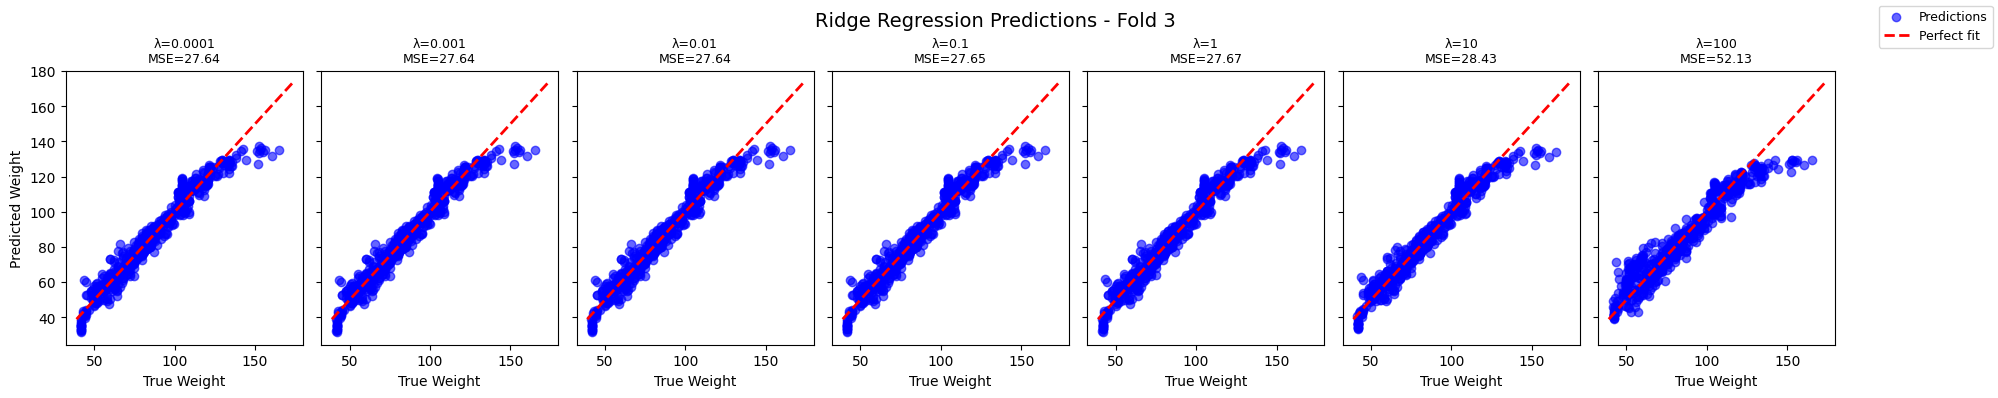

In [36]:
# K-fold crossvalidation
K = 3
CV = KFold(K, shuffle=True, random_state=0)

lambda_grid = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]


for k, (train_index, val_index) in enumerate(CV.split(X, y)):
    print(f'Fold {k+1}/{K}')
    
    # Get the training and test data for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_test = y.iloc[train_index], y.iloc[val_index]

    # Normalize data here
    mean, std = X_train.mean(axis=0), X_train.std(axis=0)
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std

    lambda_errors = {}
    for lam in lambda_grid:
            MSE = []
            # LINEAR REGRESSION MODEL
            model = Ridge(alpha=lam)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            lambda_errors[lam] = mean_squared_error(y_test, y_pred)
            print(f"  λ={lam:<6}  MSE={lambda_errors[lam]:.4f}")
    
    # Plot Ridge Regression fits per fold and λ
    fig, axs = plt.subplots(1, len(lambda_grid), figsize=(20, 4), sharey=True)
    for i, lam in enumerate(lambda_grid):
        model = Ridge(alpha=lam)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        axs[i].scatter(y_test, y_pred, color='blue', alpha=0.6, label='Predictions')
        axs[i].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect fit')
        axs[i].set_title(f'λ={lam}\nMSE={lambda_errors[lam]:.2f}', fontsize=9)
        axs[i].set_xlabel('True Weight')
        if i == 0:
            axs[i].set_ylabel('Predicted Weight')

    plt.suptitle(f'Ridge Regression Predictions - Fold {k+1}', fontsize=14)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', fontsize=9)
    plt.tight_layout()
    plt.subplots_adjust(top=0.83, right=0.92)
    plt.show()


        


### Two Layer Cross validation with 3 models

In [37]:

def cross_validation(X, y, outer_folds=10, inner_folds=10, random_state=42):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    lambda_grid = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    rows = []
    CV_outer = KFold(n_splits=outer_folds, shuffle=True, random_state=random_state)
    outer_test_mse = []
    CV_inner = KFold(n_splits=inner_folds, shuffle=True, random_state=random_state)
    inner_mse = []


    for outer_fold_idx, (outer_train_idx, outer_test_idx) in enumerate(CV_outer.split(X), start=1):
        X_train_outer, X_test_outer = X.iloc[outer_train_idx], X.iloc[outer_test_idx]
        y_train_outer, y_test_outer = y.iloc[outer_train_idx], y.iloc[outer_test_idx]

        #standerdize data 
        mean, std = X_train_outer.mean(axis=0), X_train_outer.std(axis=0)
        X_train_outer = (X_train_outer - mean) / std
        X_test_outer = (X_test_outer - mean) / std

        lambda_errors = {}
        for lam in lambda_grid:
            inner_mses = []
            for inner_train_idx, inner_test_idx in CV_inner.split(X_train_outer):
                X_train_inner = X_train_outer.iloc[inner_train_idx]
                X_test_inner = X_train_outer.iloc[inner_test_idx]
                y_train_inner = y_train_outer.iloc[inner_train_idx]
                y_test_inner = y_train_outer.iloc[inner_test_idx]

                # LINEAR REGRESSION MODEL
                model = Ridge(alpha=lam)
                model.fit(X_train_inner, y_train_inner)
                y_pred_inner = model.predict(X_test_inner)
                inner_mse.append(mean_squared_error(y_test_inner, y_pred_inner))
                E_test_lin = mean_squared_error(y_test_outer,  model.predict(X_test_outer))
                inner_mses.append(mean_squared_error(y_test_inner, y_pred_inner))
                
            lambda_errors[lam] = np.mean(inner_mses)

        best_lambda = min(lambda_errors, key=lambda_errors.get)

        # TRAIN FINAL MODEL ON FULL TRAINING SET WITH BEST LAMBDA
        model = Ridge(alpha=best_lambda)
        model.fit(X_train_outer, y_train_outer)
        E_test_lin = mean_squared_error(y_test_outer, model.predict(X_test_outer))
        outer_test_mse.append(E_test_lin)

        # BASELINE MODEL
        baseline_pred = float(np.mean(y_train_outer))       
        E_test_base = mean_squared_error(y_test_outer, np.full(len(y_test_outer), baseline_pred))

        # ANN MODEL 
        lr = 1e-3
        n_epochs = 500
        input_dim = X_train_outer.shape[1]  # Number of features
        hidden_dim = 2
        output_dim = 1
        hyperparameters_to_tune = [2, 3, 10, 15, 50]
        best_h, best_val = None, np.inf
        criterion = torch.nn.MSELoss()

        def get_model(input_dim, hidden_dim, output_dim):
            return torch.nn.Sequential(
                torch.nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=True),     # Input layer
                torch.nn.ReLU(),                                                                # Activation function
                torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True),    # Output layer
            )

        # Loop over the hyperparameter settings        
        for hidden_dim in hyperparameters_to_tune:
            fold_vals = []
            for inner_train_idx, inner_test_idx in CV_inner.split(X_train_outer):
                X_train_inner = X_train_outer.iloc[inner_train_idx]
                X_test_inner = X_train_outer.iloc[inner_test_idx]
                y_train_inner = y_train_outer.iloc[inner_train_idx]
                y_test_inner = y_train_outer.iloc[inner_test_idx]

                X_train_inner_tensor = torch.tensor(X_train_inner.values, dtype=torch.float32)
                y_train_inner_tensor = torch.tensor(y_train_inner.values, dtype=torch.float32).view(-1, 1)
                X_test_inner_tensor  = torch.tensor(X_test_inner.values, dtype=torch.float32)
                y_test_inner_tensor  = torch.tensor(y_test_inner.values, dtype=torch.float32).view(-1, 1)
            
                model = get_model(input_dim, hidden_dim, output_dim)
                optimizer = torch.optim.SGD(model.parameters(), lr=lr)
                criterion = torch.nn.MSELoss()

                for epoch in range(n_epochs):
                    model.train()
                    outputs = model(X_train_inner_tensor)
                    loss = criterion(outputs, y_train_inner_tensor)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                with torch.no_grad():
                    model.eval()
                    fold_vals.append(criterion(model(X_test_inner_tensor), y_test_inner_tensor).item())

            val_loss = np.mean(fold_vals)
            if val_loss < best_val:
                best_val = val_loss
                best_h = hidden_dim

        # TRAIN FINAL MODEL ON FULL TRAINING SET WITH BEST HYPERPARAMETER
        X_train_outer_tensor = torch.tensor(X_train_outer.values.astype(np.float32))
        y_train_outer_tensor = torch.tensor(y_train_outer.values.astype(np.float32).reshape(-1, 1))
        X_test_outer_tensor  = torch.tensor(X_test_outer.values.astype(np.float32))

        model = get_model(input_dim, best_h, output_dim)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        for _ in range(n_epochs):
            model.train()
            optimizer.zero_grad()
            loss = criterion(model(X_train_outer_tensor), y_train_outer_tensor)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            model.eval()
            E_test_ann = mean_squared_error(y_test_outer.values, model(X_test_outer_tensor).detach().numpy().ravel())

        rows.append({"Outer fold": outer_fold_idx,  "λ*_i": best_lambda, "E_test^lin": E_test_lin, "E_test^base": E_test_base,  "h*_i": best_h, "E_test^ann": E_test_ann})

    results = pd.DataFrame(rows).sort_values("Outer fold").reset_index(drop=True)
    print(results.round({"E_test^lin":2, "E_test^base":2, "E_test^ann":2}))
    print("\nAverages (MSE) across outer folds:")
    print(f"Linear regression: {results['E_test^lin'].mean():.2f}")
    print(f"Baseline:          {results['E_test^base'].mean():.2f}")
    print(f"Neural Network:    {results['E_test^ann'].mean():.2f}")

    return results
results  = cross_validation(X, y, outer_folds=10, inner_folds=10, random_state=42)


   Outer fold  λ*_i  E_test^lin  E_test^base  h*_i  E_test^ann
0           1   0.1       27.08       732.32    10       24.28
1           2   0.1       23.69       677.76    50       20.05
2           3   0.1       26.37       736.37    10       33.56
3           4   1.0       25.07       614.22    10       20.91
4           5   0.1       18.67       634.78    50       14.34
5           6   0.1       21.39       685.18    10       26.40
6           7   0.1       26.10       614.44    50       20.03
7           8   1.0       23.01       716.06    50       15.43
8           9   1.0       29.50       786.46    50       21.58
9          10   1.0       29.10       667.27    50       19.20

Averages (MSE) across outer folds:
Linear regression: 25.00
Baseline:          686.49
Neural Network:    21.58


### Stats SETUP 1

In [38]:
from scipy import stats

# example: linear vs baseline
d_lin_base = results["E_test^lin"] - results["E_test^base"]
t_stat, p_val = stats.ttest_rel(results["E_test^lin"], results["E_test^base"])

mean_diff = d_lin_base.mean()
std_diff  = d_lin_base.std(ddof=1)
n = len(d_lin_base)
ci_low  = mean_diff - 2.262 * std_diff / np.sqrt(n)
ci_high = mean_diff + 2.262 * std_diff / np.sqrt(n)

print(f"Linear vs Baseline:")
print(f"mean diff = {mean_diff:.3f}")
print(f"t = {t_stat:.3f}, p = {p_val}")
print(f"95% CI = [{ci_low:.3f}, {ci_high:.3f}]")

Linear vs Baseline:
mean diff = -661.490
t = -37.757, p = 3.1818608182198606e-11
95% CI = [-701.119, -621.861]


In [39]:
from scipy import stats

# example: linear vs ann
d_lin_base = results["E_test^ann"] - results["E_test^lin"]
t_stat, p_val = stats.ttest_rel(results["E_test^ann"], results["E_test^lin"])

mean_diff = d_lin_base.mean()
std_diff  = d_lin_base.std(ddof=1)
n = len(d_lin_base)
ci_low  = mean_diff - 2.262 * std_diff / np.sqrt(n)
ci_high = mean_diff + 2.262 * std_diff / np.sqrt(n)

print(f"Linear vs ANN:")
print(f"mean diff = {mean_diff:.3f}")
print(f"t = {t_stat:.3f}, p = {p_val}")
print(f"95% CI = [{ci_low:.3f}, {ci_high:.3f}]")

Linear vs ANN:
mean diff = -3.419
t = -1.966, p = 0.08083003266223675
95% CI = [-7.352, 0.514]


In [40]:
from scipy import stats

# example: ann vs baseline
d_ann_base = results["E_test^ann"] - results["E_test^base"]
t_stat, p_val = stats.ttest_rel(results["E_test^ann"], results["E_test^base"])

mean_diff = d_lin_base.mean()
std_diff  = d_lin_base.std(ddof=1)
n = len(d_lin_base)
ci_low  = mean_diff - 2.262 * std_diff / np.sqrt(n)
ci_high = mean_diff + 2.262 * std_diff / np.sqrt(n)

print(f"Linear vs ANN:")
print(f"mean diff = {mean_diff:.3f}")
print(f"t = {t_stat:.3f}, p = {p_val}")
print(f"95% CI = [{ci_low:.3f}, {ci_high:.3f}]")

Linear vs ANN:
mean diff = -3.419
t = -38.380, p = 2.748803188404114e-11
95% CI = [-7.352, 0.514]
